In [1]:
%reset -fs

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



In [3]:
cb_training = image_dataset_from_directory('mstar_imgs',
                                           subset='training',
                                           image_size=(128, 128),
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical')

cb_validation = image_dataset_from_directory('mstar_imgs',
                                           subset='validation',
                                           image_size=(128, 128),
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical')

Found 10595 files belonging to 9 classes.
Using 8476 files for training.
Found 10595 files belonging to 9 classes.
Using 2119 files for validation.


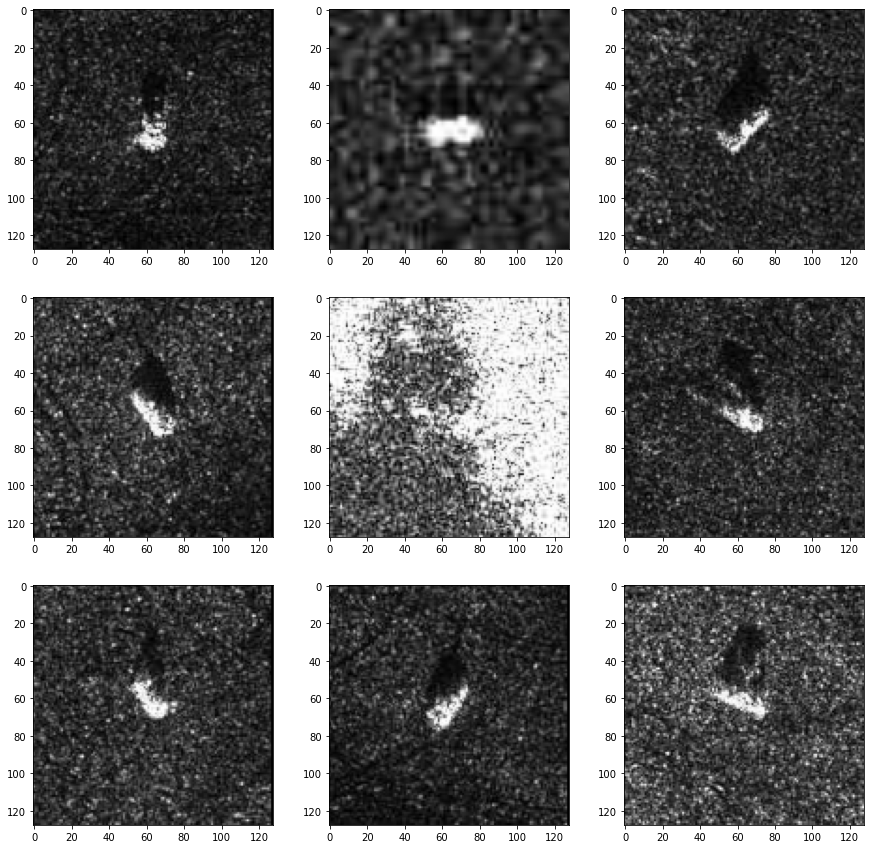

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for images, labels in cb_training.take(1):
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].numpy().astype('uint8'))

In [5]:
model = keras.Sequential()

model.add(layers.InputLayer(input_shape=(128, 128, 3)))

model.add(layers.Flatten())

model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))

model.add(layers.Dense(9, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 100)               4915300   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 9)                 909       
                                                                 
Total params: 4,936,409
Trainable params: 4,936,409
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

In [7]:
history = model.fit(cb_training, epochs=10, validation_data=cb_validation)

Epoch 1/10
265/265 [==============================] - 6s 16ms/step - loss: 168.6090 - accuracy: 0.5895 - precision: 0.4737 - recall: 0.4735 - true_positives: 4013.0000 - true_negatives: 63349.0000 - false_positives: 4459.0000 - false_negatives: 4463.0000 - val_loss: 14.9098 - val_accuracy: 0.5883 - val_precision: 0.6775 - val_recall: 0.6772 - val_true_positives: 1435.0000 - val_true_negatives: 16269.0000 - val_false_positives: 683.0000 - val_false_negatives: 684.0000
Epoch 2/10
265/265 [==============================] - 4s 15ms/step - loss: 9.0398 - accuracy: 0.5959 - precision: 0.7405 - recall: 0.7400 - true_positives: 6272.0000 - true_negatives: 65610.0000 - false_positives: 2198.0000 - false_negatives: 2204.0000 - val_loss: 6.5441 - val_accuracy: 0.5475 - val_precision: 0.6993 - val_recall: 0.6980 - val_true_positives: 1479.0000 - val_true_negatives: 16316.0000 - val_false_positives: 636.0000 - val_false_negatives: 640.0000
Epoch 3/10
265/265 [==============================] - 4s 15